In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn_evaluation.plot import grid_search
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity

import statsmodels.api as sm  # For fitting statistical models
import statsmodels.formula.api as smf  # For fitting statistical models using formulas


In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Crimes_2022.csv')

In [2]:
df = pd.read_pickle('Chicago_crime_2022_cleaned.pickle')

In [4]:
df.head()

,Date,IUCR,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Latitude,Longitude
2,2022-08-14 14:00:00,1562,AGGRAVATED CRIMINAL SEXUAL ABUSE,RESIDENCE,0,0,1621,16,39.0,11,17,41.985875,-87.766404
5,2022-02-19 10:36:00,486,DOMESTIC BATTERY SIMPLE,HOSPITAL BUILDING / GROUNDS,1,1,1211,12,26.0,24,8,41.900506,-87.699285
12,2022-09-16 07:00:00,320,STRONG ARM - NO WEAPON,APARTMENT,0,0,1411,14,35.0,21,3,41.935972,-87.703859
13,2022-10-30 05:30:00,326,AGGRAVATED VEHICULAR HIJACKING,STREET,0,0,113,1,34.0,32,3,41.878224,-87.627131
14,2022-11-05 12:49:00,620,UNLAWFUL ENTRY,WAREHOUSE,1,0,1111,11,37.0,23,5,41.896112,-87.737267


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239602 entries, 0 to 239601
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    239602 non-null  int64  
 1   Case Number           239602 non-null  object 
 2   Date                  239602 non-null  object 
 3   Block                 239602 non-null  object 
 4   IUCR                  239602 non-null  object 
 5   Primary Type          239602 non-null  object 
 6   Description           239602 non-null  object 
 7   Location Description  238633 non-null  object 
 8   Arrest                239602 non-null  bool   
 9   Domestic              239602 non-null  bool   
 10  Beat                  239602 non-null  int64  
 11  District              239602 non-null  int64  
 12  Ward                  239592 non-null  float64
 13  Community Area        239602 non-null  int64  
 14  FBI Code              239602 non-null  object 
 15  

In [5]:
df.shape

(78084, 13)

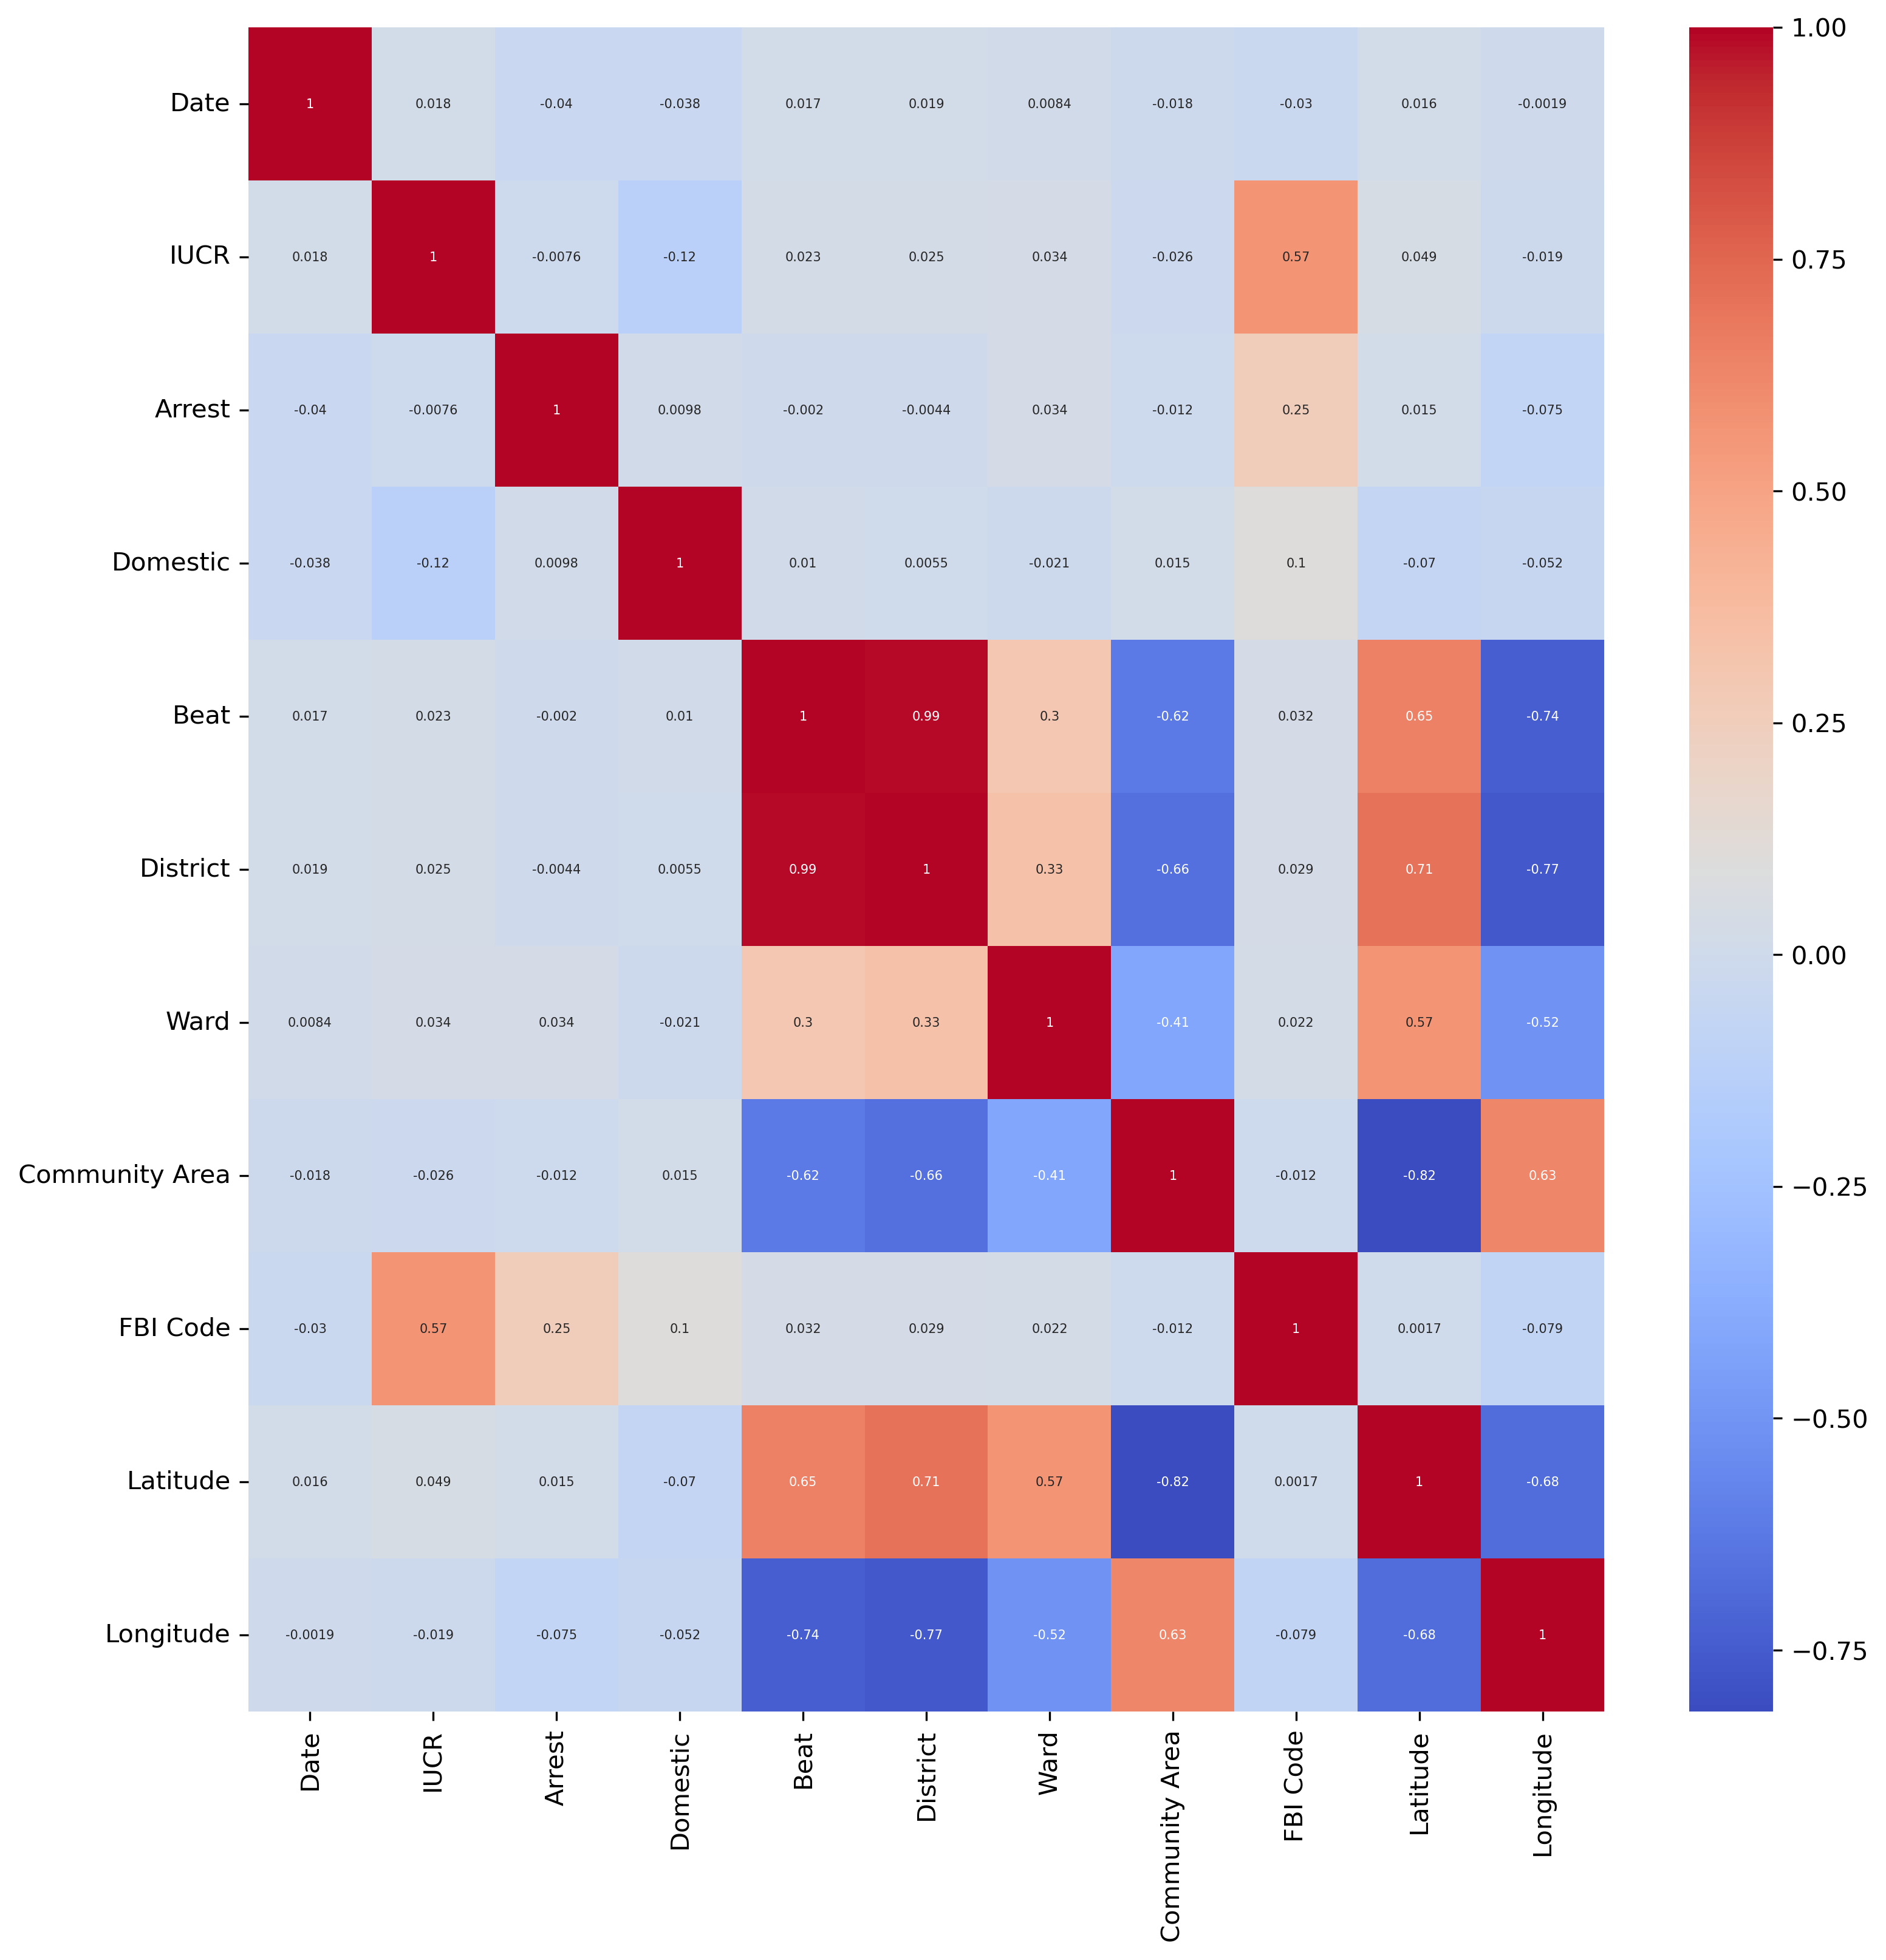

In [7]:
cat_cols = list(df.select_dtypes(include='object').columns)
plt.figure(figsize=(12,12),dpi=300)
corr = df.drop(columns=cat_cols).corr(method = 'spearman')
sns.heatmap(corr, cmap ='coolwarm',fmt='.2g',annot=True, annot_kws={"size":5}, xticklabels=1, yticklabels=1)
plt.savefig('SpearmanCorrHeat.jpg', format='jpeg', dpi=300, bbox_inches ='tight')

# Data Split & Preprocessing

In [8]:
X = df.drop(columns=['Arrest'])
y = df['Arrest']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [9]:
num_cols = list(X_train.select_dtypes(include=np.number).columns)
cat_cols = list(X_train.select_dtypes(include='object').columns)

In [10]:
print(num_cols)
print(cat_cols)

['IUCR', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'Latitude', 'Longitude']
['Description', 'Location Description']


In [11]:
rf = RandomForestClassifier()
ct = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('desc', TargetEncoder(), ['Description']),
    ('loc_desc',OneHotEncoder(handle_unknown='ignore'), ['Location Description'])
])

pipe_rf = Pipeline([
    ('ct', ct),
    ('clf', rf)

])
param_grid_rf = [{'clf':[rf], 'clf__max_depth': [2,4,6], 'clf__n_estimators': [200,500,1000]}]

np.random.seed(7)
gridSearch_rf = GridSearchCV(pipe_rf, param_grid=param_grid_rf, scoring='r2', n_jobs=-1, cv=5)
gridSearch_rf.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['IUCR',
                                                                          'Domestic',
                                                                          'Beat',
                                                                          'District',
                                                                          'Ward',
                                                                          'Community '
                                                                          'Area',
                                                                          'FBI '
                                                                          'Code',
                                                                          'Latitude',
                                                                          'Longitude']),
                                                                        ('desc',
                                                                         TargetEncoder(),
                                                                         ['Description']),
                                                                        ('loc_desc',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Location '
                                                                          'Description'])])),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'clf': [RandomForestClassifier()],
                          'clf__max_depth': [2, 4, 6],
                          'clf__n_estimators': [200, 500, 1000]}],
             scoring='r2')

<Axes: title={'center': 'Grid search results'}, xlabel='clf__n_estimators', ylabel='Mean score'>

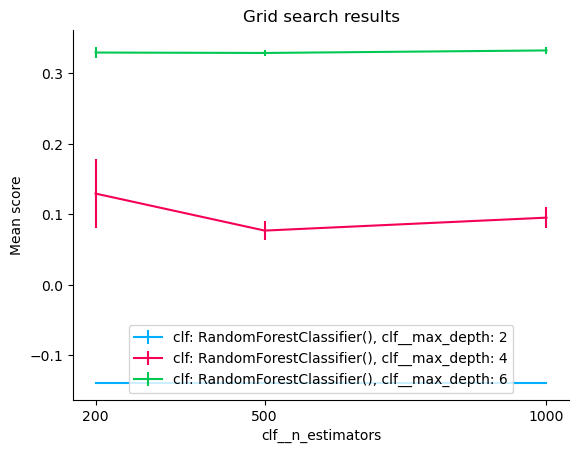

In [13]:
fig = plt.figure
grid_search(gridSearch_rf.cv_results_, change='clf__n_estimators')

In [ ]:
# Save the model to disk
joblib.dump(gridSearch_rf, 'model_cache.pkl')

# Load the model from disk when needed
# loaded_model = joblib.load('model_cache.pkl')
